In [1]:
import numpy as np
import matplotlib.pylab as plt
import scienceplots as sp

In [2]:
import scipy 

In [3]:
plt.style.use('nature')

In [4]:
# the single chain cases
theo_sc_names = ['theoA','theoB','TAL1A','TAL1B','TAL1C','TAL1D','TAL2A','TAL2B','TAL3A','TAL3B']



In [5]:
# experimental data
theo_expt = [-8.42,-11.86,-10.96,-10.42] #kcal/mol # 25 degress, 298 K

In [6]:
# the effective runs for each cas
theo_sc_eruns = [80,70,70,63,70,69,60,40,70,70]

In [7]:
theo_sc_runs = dict(zip(theo_sc_names,theo_sc_eruns))

In [8]:
print (theo_sc_runs)

{'theoA': 80, 'theoB': 70, 'TAL1A': 70, 'TAL1B': 63, 'TAL1C': 70, 'TAL1D': 69, 'TAL2A': 60, 'TAL2B': 40, 'TAL3A': 70, 'TAL3B': 70}


In [9]:
# single chain 80 58 70 60 40 70
theoSC={}
for i in theo_sc_names:
    theoSC[i] =  [np.loadtxt("Theoseris/"+i+"/fes_"+str(j)+".dat",comments="#") for j in np.arange(1,theo_sc_runs[i]+1)]


In [10]:
# crystal packing data
theo_cp_runs = {'theoA-cp': 66,
               'theoB-cp':  56,
               'TAL1A-cp':  62,
               'TAL1C-cp':  56,
                'TAL2A-cp': 69,
                'TAL2B-cp': 57,
                'TAL3A-cp': 66,
                'TAL3B-cp': 67
               }

In [11]:
theo_cp_names = ['theoA-cp','theoB-cp','TAL1A-cp','TAL1C-cp','TAL2A-cp','TAL2B-cp','TAL3A-cp','TAL3B-cp']

In [12]:
theoCP={}
for i in theo_cp_names:
    theoCP[i] =  [np.loadtxt("Theoseris/"+i+"/fes_"+str(j)+".dat",comments="#") for j in np.arange(1,theo_cp_runs[i]+1)]

In [13]:
def discretize_FES(data,cv_min=0.0,cv_max=7.0,bins=200):
    """
    For each fes.dat obtained from plumed metadynamics, we will first discretized the fes values into 
    binds alone the CV (from cv_min to cv_max) with number of bins as 200.
    The purpose is to standarlized each fes curve, and after this process, difference fes curves can be added 
    and the average energy at each bin (center) can be calculated
    This idea is from Scientific Reports | (2022) 12:2024 
    """
    width= (cv_max - cv_min)/bins
    
    cv_grids = np.linspace(cv_min,cv_max,bins+1)
    
    newFES = []
    
    Npoints=len(data[:,0])
    #print (Npoints)
    for z,j in enumerate(cv_grids):
        flag = 0
        
        for i in range(Npoints-1):
            if (data[i,0] - j)*(data[i+1,0]-j) <= 0:
                flag = 1
                
                # linear interpolation: e = e1 + (D-D1)[(e2-e1)/(D2-D1)]
                energy = data[i,1] + (j-data[i,0])*(data[i+1,1]-data[i,1])/(data[i+1,0]-data[i,0])
        if flag == 1:
            newFES.append(energy)
        else:
            newFES.append(0.0)
    return newFES
                
        

In [14]:
CV_grids = np.linspace(0,7.0,201)

In [15]:
# discretizing the energy curves
theoSCdiscre={}
for i in theo_sc_names:
    theoSCdiscre[i] = [discretize_FES(theoSC[i][j]) for j in range(theo_sc_runs[i])]
    


In [16]:
theoCPdiscre={}
for i in theo_cp_names:
    theoCPdiscre[i] = [discretize_FES(theoCP[i][j]) for j in range(theo_cp_runs[i])]

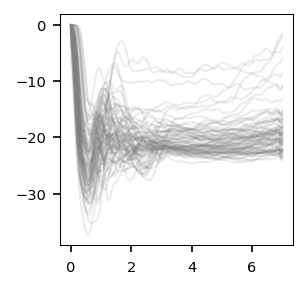

In [17]:
plt.figure(figsize=(2,2),dpi=150)
for i in range(theo_sc_runs['theoA']):
    plt.plot(CV_grids,np.asarray(theoSCdiscre['theoA'][i])*0.239,color='gray',alpha=0.15)

In [18]:
def calculate_aveFES(gridFes):
    """
    calculate the everage FES using the discretized FES curves
    """
    newgrid = np.asarray(gridFes)
    avgFEs = np.average(newgrid,axis=0)
    
    return avgFEs
    

In [19]:
plt.style.use('nature')

Text(0.5, 0, 'RC (nm)')

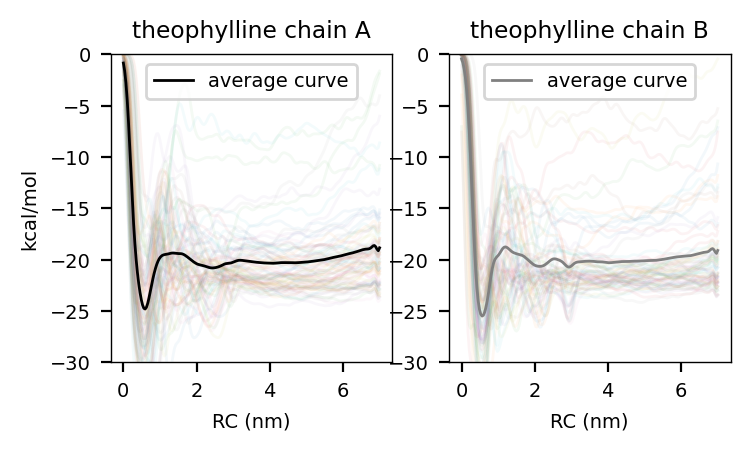

In [20]:
plt.figure(figsize=(4,2),dpi=200)
colors = ['red','green','blue','yellow','magenta']
plt.subplot(1,2,1)
for i in range(80):
    plt.plot(CV_grids,np.asarray(theoSCdiscre['theoA'][i])*0.239,alpha=0.05)
    #plt.plot(data[i][:,0],data[i][:,1],label="orginal"+str(i+1),color=colors[i])
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['theoA'])*0.239,label="average curve",color='black')
plt.title('theophylline chain A')
plt.ylim([-30,0])
plt.legend()
plt.ylabel("kcal/mol")
plt.xlabel("RC (nm)")

plt.subplot(1,2,2)
for i in range(70):
    plt.plot(CV_grids,np.asarray(theoSCdiscre['theoB'][i])*0.239,alpha=0.05)
    #plt.plot(data[i][:,0],data[i][:,1],label="orginal"+str(i+1),color=colors[i])
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['theoB'])*0.239,label="average curve",color='gray')
plt.title('theophylline chain B')
plt.ylim([-30,0])
plt.legend()
#plt.ylabel("kcal/mol")
plt.xlabel("RC (nm)")

In [21]:
# now calculate the convergence of deltaG as a function of iteration number 

def deltaG_converge(allgridFes,nruns=5,minx=25, maxinx=150):
    """
    calculate the deltaG using different number of metadynamics runs
    We will first need to define the bound state (cv_bound=0.6) and 
    unbound state (cv_unbound=2.2) on the CV
    """
    deltaG=[]
    for i in range(1,nruns+1):
        t_gridEFS = allgridFes[0:i]
        averageFES = calculate_aveFES(t_gridEFS)
        deltaG.append(np.mean(averageFES[minx-2:minx+2])-np.mean(averageFES[maxinx-2:maxinx+2]))
    return deltaG
    

In [22]:
theoSCmins = {}
for i in theo_sc_names:
    theoSCmins[i] = np.argmin(calculate_aveFES(theoSCdiscre[i]))


print (CV_grids[150])

5.250000000000001


In [23]:
theoCPmins = {}
for i in theo_cp_names:
    theoCPmins[i] = np.argmin(calculate_aveFES(theoCPdiscre[i]))

In [24]:
theoSCdeltaG = {}
for i in theo_sc_names:
    theoSCdeltaG[i] = deltaG_converge(theoSCdiscre[i],minx=theoSCmins[i],nruns=theo_sc_runs[i])

In [25]:
theoCPdeltaG = {}
for i in theo_cp_names:
    theoCPdeltaG[i] = deltaG_converge(theoCPdiscre[i],minx=theoCPmins[i],nruns=theo_cp_runs[i])

(-20.0, 0.0)

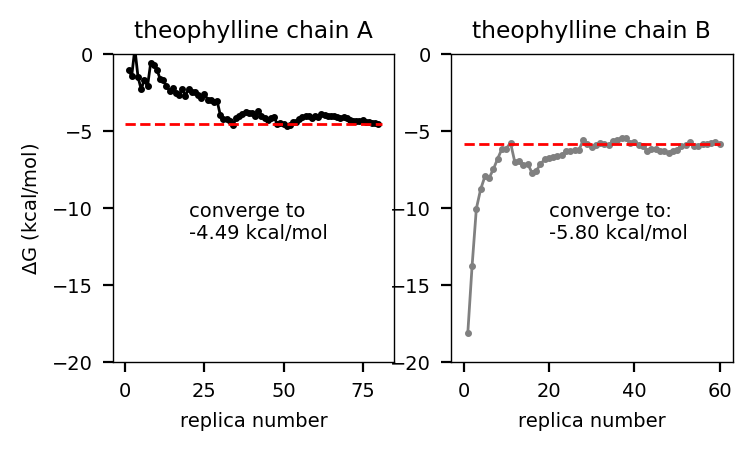

In [26]:
plt.figure(figsize=(4,2),dpi=200)
plt.subplot(1,2,1)
plt.plot(np.arange(1,81),np.asarray(theoSCdeltaG['theoA'])*0.239,".-",color='black')
plt.xlabel("replica number")
plt.ylabel("$\Delta$G (kcal/mol)")
plt.title("theophylline chain A")
plt.plot([0,81],[-4.49,-4.49],'r--')
plt.text(20,-12,"converge to \n-4.49 kcal/mol")
#plt.ylabel("binding free energy (kcal/mol)")
plt.ylim([-20,0])

plt.subplot(1,2,2)
plt.plot(np.arange(1,61),np.asarray(theoSCdeltaG['theoB'][:60])*0.239,".-",color='gray')
plt.plot([0,60],[-5.80,-5.80],'r--')
plt.text(20,-12,"converge to: \n-5.80 kcal/mol")
#plt.ylim([-18,-5])
plt.xlabel("replica number")
plt.title("theophylline chain B")
plt.ylim([-20,0])
#plt.plot([0,60],[-14.

In [27]:
for i in theo_sc_names:
    print (np.mean(theoSCdeltaG[i][-3:])*0.239)

-4.490023322158975
-5.2051534439005
-1.1134651234051405
-1.2954781828121809
-1.558454230346189
-1.4384672560073752
-1.2257432458517614
-0.3324555670832611
-1.0608564525509445
-2.1973351897502167


In [28]:
for i in theo_cp_names:
    print (np.mean(theoCPdeltaG[i][-3:])*0.239)

-8.117358421849385
-8.138973105134491
-6.452969319740206
-12.33454971217225
-0.5948705347972978
-10.274150970535567
-7.447763509494716
-2.768799395202359


In [29]:
plt.style.use('nature')

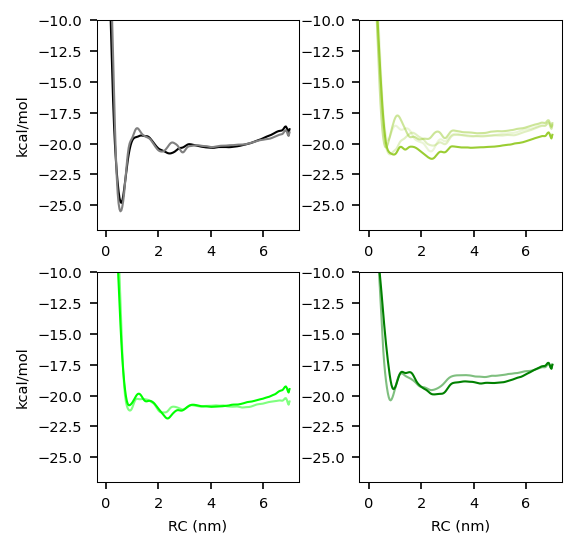

In [30]:
plt.figure(figsize=(4,4),dpi=150)
plt.subplot(2,2,1)
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['theoA'])*0.239,label="average curve",color='black')
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['theoB'])*0.239,label="average curve",color='gray')
plt.ylim([-27,-10])
plt.ylabel('kcal/mol')

plt.subplot(2,2,2)
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['TAL1A'])*0.239,label="average curve",color='yellowgreen')
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['TAL1B'])*0.239,label="average curve",color='yellowgreen',alpha=0.5)
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['TAL1C'])*0.239,label="average curve",color='yellowgreen',alpha=0.3)
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['TAL1D'])*0.239,label="average curve",color='yellowgreen',alpha=0.2)
plt.ylim([-27,-10])

plt.subplot(2,2,3)
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['TAL2A'])*0.239,label="average curve",color='lime')
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['TAL2B'])*0.239,label="average curve",color='lime',alpha=0.5)
plt.ylim([-27,-10])
plt.ylabel('kcal/mol')
plt.xlabel('RC (nm)')


plt.subplot(2,2,4)
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['TAL3A'])*0.239,label="average curve",color='green')
plt.plot(CV_grids,calculate_aveFES(theoSCdiscre['TAL3B'])*0.239,label="average curve",color='green',alpha=0.5)
plt.ylim([-27,-10])
plt.xlabel('RC (nm)')

plt.subplots_adjust(wspace=0.3)

In [31]:
for i in theo_cp_names:
    print (np.std(theoCPdeltaG[i][-3:])*0.239)

0.05914494350552955
0.17343642119762961
0.09587171701293651
0.1263556267237249
0.042868839598004305
0.17366143990113028
0.05143634094599773
0.017799542942101416


In [33]:
print (np.argmin(calculate_aveFES(theoA_grid_fes)))
print (np.argmin(calculate_aveFES(theoB_grid_fes)))

print (np.argmin(calculate_aveFES(theoA_grid_fes_cp)))
print (np.argmin(calculate_aveFES(theoB_grid_fes_cp)))

print (CV_grids[150])

NameError: name 'theoA_grid_fes' is not defined

In [34]:
# now calculate the convergence of deltaG as a function of iteration number 

def deltaG_converge(allgridFes,nruns=5,minx=25, maxinx=150):
    """
    calculate the deltaG using different number of metadynamics runs
    We will first need to define the bound state (cv_bound=0.6) and 
    unbound state (cv_unbound=2.2) on the CV
    """
    deltaG=[]
    for i in range(1,nruns+1):
        t_gridEFS = allgridFes[0:i]
        averageFES = calculate_aveFES(t_gridEFS)
        deltaG.append(np.mean(averageFES[minx-2:minx+2])-np.mean(averageFES[maxinx-2:maxinx+2]))
    return deltaG
    
        
        
        
    

In [35]:
theoA_deltaG = deltaG_converge(theoA_grid_fes,minx=17,nruns=80)
theoB_deltaG = deltaG_converge(theoB_grid_fes,minx=16,nruns=58)

NameError: name 'theoA_grid_fes' is not defined

In [36]:
theoA_final = np.mean(theoA_deltaG[-3:])*0.239
theoB_final = np.mean(theoB_deltaG[-3:])*0.239

NameError: name 'theoA_deltaG' is not defined

In [29]:
print (theoA_deltaG[-3:])
print (theoB_deltaG[-3:])

[-18.70045909676861, -18.733403071290795, -18.92626321468923]
[-24.280349106458644, -24.30476026292648, -24.241850274943502]


In [27]:
print (theoA_final,theoB_final)

-4.490023322158975 -5.801881118331514


(-20.0, 0.0)

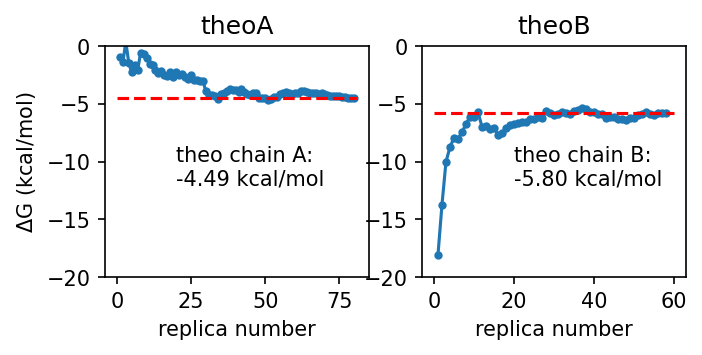

In [35]:
plt.figure(figsize=(5,2),dpi=150)
plt.subplot(1,2,1)
plt.plot(np.arange(1,81),np.asarray(theoA_deltaG)*0.239,".-")
#plt.ylim([-18,-5])
plt.xlabel("replica number")
plt.ylabel("$\Delta$G (kcal/mol)")
plt.title("theoA")
plt.plot([0,81],[-4.49,-4.49],'r--')
plt.text(20,-12,"theo chain A: \n-4.49 kcal/mol")
#plt.ylabel("binding free energy (kcal/mol)")
plt.ylim([-20,0])
plt.subplot(1,2,2)
plt.plot(np.arange(1,59),np.asarray(theoB_deltaG)*0.239,".-")
plt.plot([0,60],[-5.80,-5.80],'r--')
plt.text(20,-12,"theo chain B: \n-5.80 kcal/mol")
#plt.ylim([-18,-5])
plt.xlabel("replica number")
plt.title("theoB")
plt.ylim([-20,0])
#plt.plot([0,60],[-14.

(-20.0, 0.0)

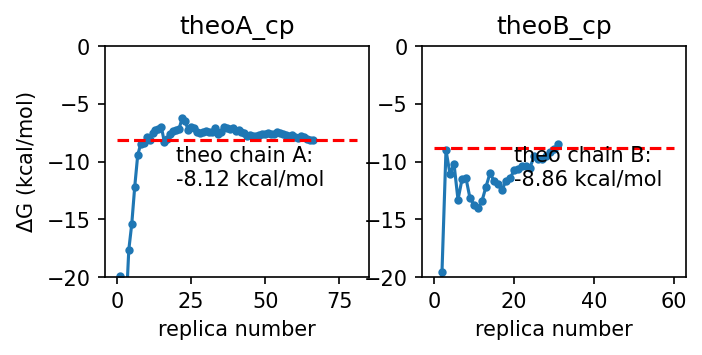

In [62]:
plt.figure(figsize=(5,2),dpi=150)
plt.subplot(1,2,1)
plt.plot(np.arange(1,67),np.asarray(theoA_deltaG_cp)*0.239,".-")
#plt.ylim([-18,-5])
plt.xlabel("replica number")
plt.ylabel("$\Delta$G (kcal/mol)")
plt.title("theoA_cp")
plt.plot([0,81],[-8.12,-8.12],'r--')
plt.text(20,-12,"theo chain A: \n-8.12 kcal/mol")
#plt.ylabel("binding free energy (kcal/mol)")
plt.ylim([-20,0])
plt.subplot(1,2,2)
plt.plot(np.arange(1,32),np.asarray(theoB_deltaG_cp)*0.239,".-")
plt.plot([0,60],[-8.86,-8.86],'r--')
plt.text(20,-12,"theo chain B: \n-8.86 kcal/mol")
#plt.ylim([-18,-5])
plt.xlabel("replica number")
plt.title("theoB_cp")
plt.ylim([-20,0])
#plt.plot([0,60],[-14.

In [57]:
theoA_deltaG_cp = deltaG_converge(theoA_grid_fes_cp,minx=16,nruns=66)
theoB_deltaG_cp = deltaG_converge(theoB_grid_fes_cp,minx=18,nruns=31)

In [58]:
theoA_final_cp = np.mean(theoA_deltaG_cp[-3:])*0.239
theoB_final_cp = np.mean(theoB_deltaG_cp[-3:])*0.239

In [59]:
print (theoA_final_cp,theoB_final_cp)

-8.117358421849385 -8.861070335064266


(-30.0, 0.0)

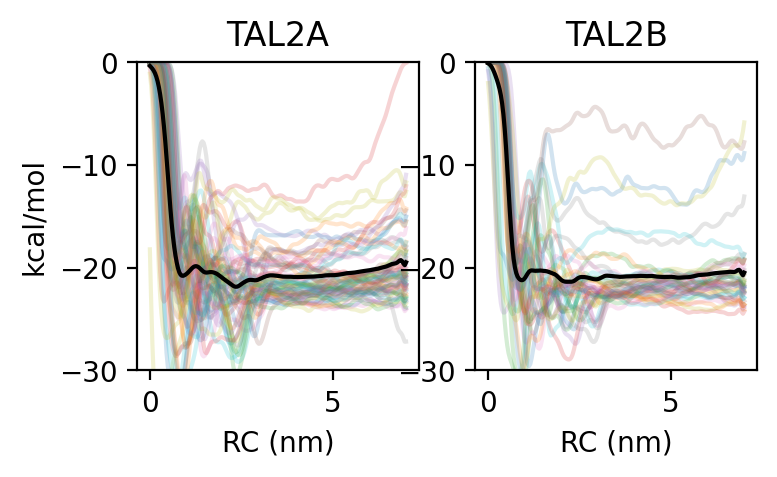

In [46]:
plt.figure(figsize=(4,2),dpi=200)
colors = ['red','green','blue','yellow','magenta']
plt.subplot(1,2,1)
for i in range(60):
    plt.plot(CV_grids,np.asarray(TAL2A_grid_fes[i])*0.239,label='discretize'+str(i+1),alpha=0.2)
    #plt.plot(data[i][:,0],data[i][:,1],label="orginal"+str(i+1),color=colors[i])
plt.plot(CV_grids,calculate_aveFES(TAL2A_grid_fes)*0.239,label="avg",color='black')
plt.title('TAL2A')
plt.ylim([-30,0])
plt.ylabel("kcal/mol")
plt.xlabel("RC (nm)")

plt.subplot(1,2,2)
for i in range(40):
    plt.plot(CV_grids,np.asarray(TAL2B_grid_fes[i])*0.239,label='discretize'+str(i+1),alpha=0.2)
    #plt.plot(data[i][:,0],data[i][:,1],label="orginal"+str(i+1),color=colors[i])
plt.plot(CV_grids,calculate_aveFES(TAL2B_grid_fes)*0.239,label="avg",color='black')
plt.title('TAL2B')
plt.xlabel("RC (nm)")
plt.ylim([-30,0])


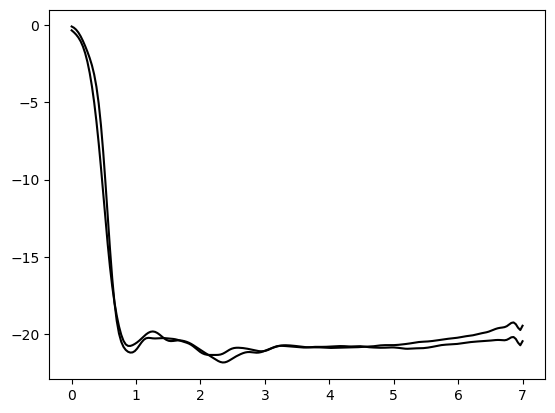

In [47]:
plt.plot(CV_grids,calculate_aveFES(TAL2A_grid_fes)*0.239,label="avg_TAL2A",color='black')
plt.plot(CV_grids,calculate_aveFES(TAL2B_grid_fes)*0.239,label="avg_TAL2B",color='black')

In [71]:
TAL1_sc_grid_fes = [discretize_FES(TAL1_sc_data[i]) for i in range(58)]
TAL2_sc_grid_fes = [discretize_FES(TAL2_sc_data[i]) for i in range(35)]
TAL3_sc_grid_fes = [discretize_FES(TAL3_sc_data[i]) for i in range(46)]

Text(0, 0.5, '$\\Delta$G (kcal/mol)')

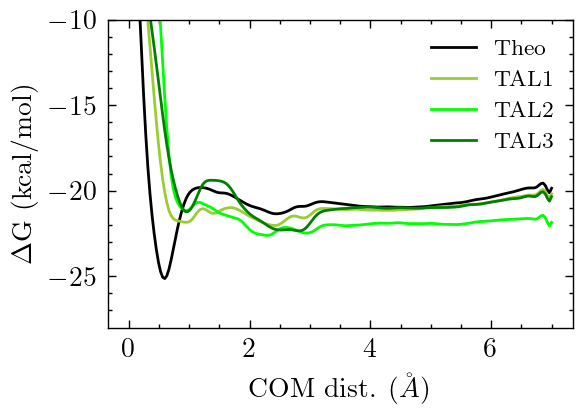

In [82]:
plt.figure(figsize=(3,2),dpi=200)
plt.plot(CV_grids,calculate_aveFES(grid_fes)*0.239,label="Theo",color='black')
plt.plot(CV_grids,calculate_aveFES(TAL1_sc_grid_fes)*0.239,label="TAL1",color='yellowgreen')
plt.plot(CV_grids,calculate_aveFES(TAL2_sc_grid_fes)*0.239,label="TAL2",color='lime')
plt.plot(CV_grids,calculate_aveFES(TAL3_sc_grid_fes)*0.239,label="TAL3",color='green')
plt.ylim([-28,-10])
plt.legend(fontsize=8)
plt.xlabel("COM dist. ($\AA$)")
plt.ylabel("$\Delta$G (kcal/mol)")

In [99]:
print (np.argmin(calculate_aveFES(TAL1_sc_grid_fes)))
print (np.argmin(calculate_aveFES(TAL2_sc_grid_fes)))
print (np.argmin(calculate_aveFES(TAL3_sc_grid_fes)))

69
65
80


In [103]:
TAL1_sc_deltaG = deltaG_converge(TAL1_sc_grid_fes,minndx=69,nruns=58)
TAL2_sc_deltaG = deltaG_converge(TAL2_sc_grid_fes,minndx=65,nruns=35)
TAL3_sc_deltaG = deltaG_converge(TAL1_sc_grid_fes,minndx=80,nruns=46)

In [37]:
from scipy import stats

In [38]:
theo_expt = [-8.42, -8.42, -11.86,-11.86,-11.86,-11.86,-10.96,-10.96,-10.42,-10.42] 
sc_deltaG = [-4.49,-5.80,-1.11,1.295,-1.56,-1.44,-1.23,-0.33,-1.06,-2.20]
#calc =  [-4.4,-0.7,-0.65,-0.3]
res = scipy.stats.linregress(theo_expt, sc_deltaG)

In [39]:
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.732318


In [40]:
expts = list(zip(theo_expt,sc_deltaG))
exptvales = np.linspace(-12,-7,50)

In [41]:
colors = ['black','gray','yellowgreen','yellowgreen','yellowgreen','yellowgreen','lime','lime','green','green']
cases = ['Theo','TAL1','TAL2','TAL3']
alphas = [1.0,1.0,1.0,0.6,0.5,0.3,0.2,1.0,0.5,1.0,0.5]

Text(-12, -4, 'R$^2$ = 0.73')

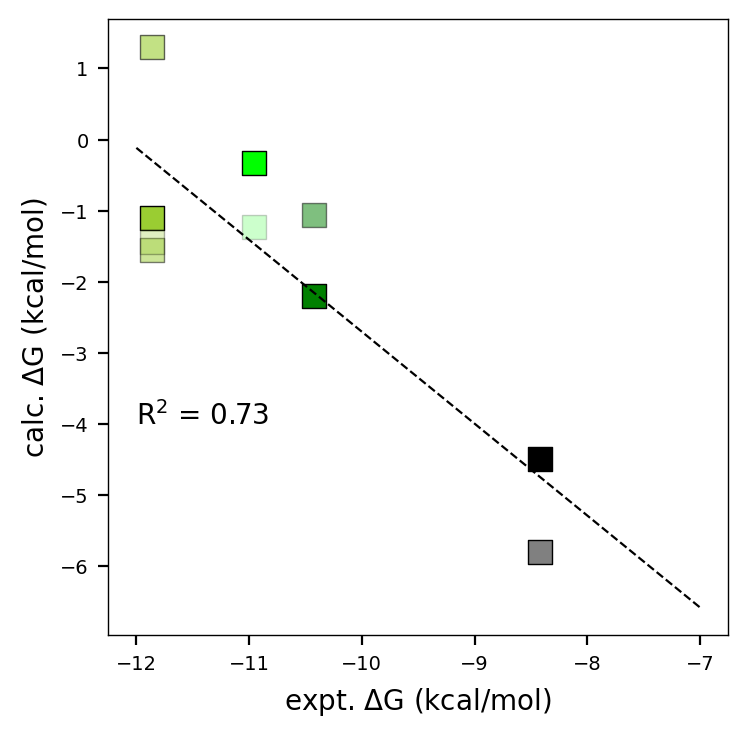

In [42]:
plt.figure(figsize=(4,4),dpi=200)
#plt.title("Theo-series")
for i,j in enumerate(expts):
    
    plt.scatter(j[0],j[1],marker="s",color=colors[i],s=70,alpha=alphas[i],edgecolor='black',linewidth=0.5)
plt.plot(exptvales,res.slope*exptvales+res.intercept,'k--',lw=0.8)
plt.xlabel("expt. $\Delta$G (kcal/mol)",fontsize=10)
plt.ylabel("calc. $\Delta$G (kcal/mol)",fontsize=10)
plt.text(-12,-4,"R$^2$ = 0.73",fontsize=10)
#plt.legend(fontsize=6)

In [82]:
theo_expt = [-8.42, -8.42, -11.86,-11.86,-10.96,-10.96,-10.42,-10.42] 
cp_deltaG = [-8.12,-8.14,-6.45,-12.33,-0.59,-10.27,-7.45,-2.77]
#calc =  [-4.4,-0.7,-0.65,-0.3]
res = scipy.stats.linregress(theo_expt, cp_deltaG)



In [83]:
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.000347


In [84]:
expts = list(zip(theo_expt,cp_deltaG))
exptvales = np.linspace(-12,-7,50)

In [85]:
colors = ['black','gray','yellowgreen','yellowgreen','lime','lime','green','green']
cases = ['Theo','TAL1','TAL2','TAL3']
alphas = [0.4,1.0,0.6,1.0,0.3,1.0,1.0,0.5]

Text(-10.5, -6, 'R$^2$ = 0.0003')

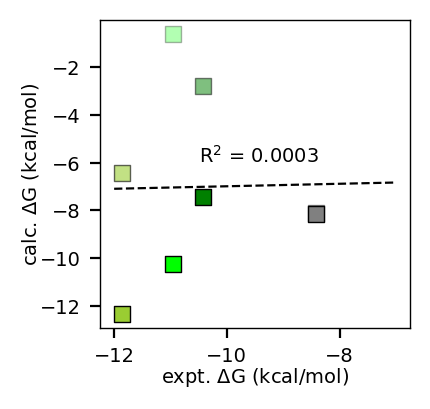

In [89]:
plt.figure(figsize=(2,2),dpi=200)
#plt.title("Theo-series")
for i,j in enumerate(expts):
    
    plt.scatter(j[0],j[1],marker="s",color=colors[i],s=30,alpha=alphas[i],edgecolor='black',linewidth=0.5)
plt.plot(exptvales,res.slope*exptvales+res.intercept,'k--',lw=0.8)
plt.xlabel("expt. $\Delta$G (kcal/mol)",labelpad=0)
plt.ylabel("calc. $\Delta$G (kcal/mol)",labelpad=-0.5)
plt.text(-10.5,-6,"R$^2$ = 0.0003")
#plt.legend(fontsize=6)

In [74]:
theo_expt = [-8.42, -11.86,-10.96,-10.42] 
cp_deltaG = [-8.14,-12.33,-10.27,-7.45]
#calc =  [-4.4,-0.7,-0.65,-0.3]
res = scipy.stats.linregress(theo_expt, cp_deltaG)




In [75]:
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.557975


In [76]:
expts = list(zip(theo_expt,cp_deltaG))
exptvales = np.linspace(-12,-7,50)

In [77]:
colors = ['black','yellowgreen','lime','green']
cases = ['Theo','TAL1','TAL2','TAL3']
alphas = [1.0,1.0,1.0,1.0]

Text(-10, -10, 'R$^2$ = 0.56')

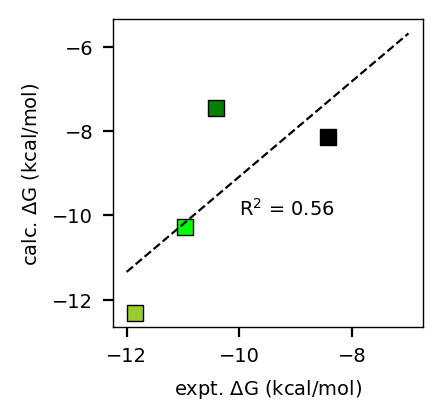

In [81]:
plt.figure(figsize=(2,2),dpi=200)
#plt.title("Theo-series")
for i,j in enumerate(expts):
    
    plt.scatter(j[0],j[1],marker="s",color=colors[i],s=30,alpha=alphas[i],edgecolor='black',linewidth=0.5)
plt.plot(exptvales,res.slope*exptvales+res.intercept,'k--',lw=0.8)
plt.xlabel("expt. $\Delta$G (kcal/mol)")
plt.ylabel("calc. $\Delta$G (kcal/mol)")
plt.text(-10,-10,"R$^2$ = 0.56")
#plt.legend(fontsize=6)

In [112]:
TAL3A_cp_data = [np.loadtxt("temp/TAL3A_cp/fes_"+str(i)+".dat",comments="#") for i in np.arange(1,71)]

In [113]:
TAL3A_cp_grid_fes = [discretize_FES(TAL3A_cp_data[i]) for i in range(70)]

In [104]:
TAL1A_cp_data = [np.loadtxt("temp/TAL1A_cp/filter/fes_"+str(i)+".dat",comments="#") for i in np.arange(1,69)]

In [73]:
TAL2A_cp_data = [np.loadtxt("temp/TAL2A_cp/fes_"+str(i)+".dat",comments="#") for i in np.arange(2,41)]

In [13]:
Theo_cp_grid_fes = [discretize_FES(Theo_cp_data[i]) for i in range(66)]
TAL1_cp_grid_fes = [discretize_FES(TAL1_cp_data[i]) for i in range(60)]
TAL2_cp_grid_fes = [discretize_FES(TAL2_cp_data[i]) for i in range(34)]
TAL3_cp_grid_fes = [discretize_FES(TAL3_cp_data[i]) for i in range(65)]

In [86]:
TAL3B_cp_grid_fes = [discretize_FES(TAL3B_cp_data[i]) for i in range(38)]
TAL2A_cp_grid_fes = [discretize_FES(TAL2A_cp_data[i]) for i in range(39)]

In [105]:
TAL1A_cp_grid_fes = [discretize_FES(TAL1A_cp_data[i]) for i in range(68)]

In [87]:
TAL3A_cp_same_grid_fes = [discretize_FES(TAL3A_cp_same_data[i]) for i in range(34)]

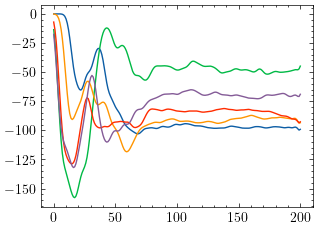

In [23]:
plt.plot(Theo_cp_grid_fes[0])
plt.plot(Theo_cp_grid_fes[1])
plt.plot(Theo_cp_grid_fes[2])
plt.plot(Theo_cp_grid_fes[3])
plt.plot(Theo_cp_grid_fes[4])

Text(0, 0.5, '$\\Delta$G (kcal/mol)')

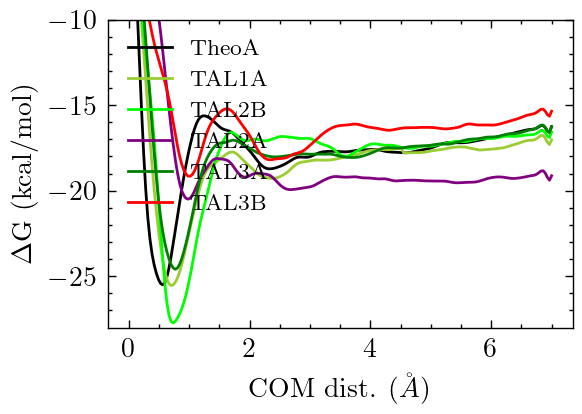

In [108]:
plt.figure(figsize=(3,2),dpi=200)
plt.plot(CV_grids,calculate_aveFES(Theo_cp_grid_fes)*0.239,label="TheoA",color='black')
plt.plot(CV_grids,calculate_aveFES(TAL1A_cp_grid_fes)*0.239,label="TAL1A",color='yellowgreen')
plt.plot(CV_grids,calculate_aveFES(TAL2_cp_grid_fes)*0.239,label="TAL2B",color='lime')
plt.plot(CV_grids,calculate_aveFES(TAL2A_cp_grid_fes)*0.239,label="TAL2A",color='purple')
plt.plot(CV_grids,calculate_aveFES(TAL3_cp_grid_fes)*0.239,label="TAL3A",color='green')
plt.plot(CV_grids,calculate_aveFES(TAL3B_cp_grid_fes)*0.239,label="TAL3B",color='red')
#plt.plot(CV_grids,calculate_aveFES(TAL3A_cp_same_grid_fes)*0.239,label="TAL3A_same",color='red')
plt.ylim([-28,-10])
plt.legend(fontsize=8)
plt.xlabel("COM dist. ($\AA$)")
plt.ylabel("$\Delta$G (kcal/mol)")

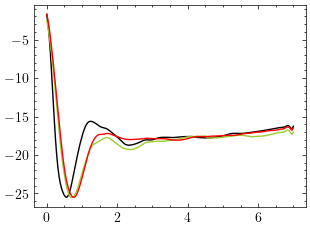

In [114]:
plt.plot(CV_grids,calculate_aveFES(Theo_cp_grid_fes)*0.239,label="TheoA",color='black')
plt.plot(CV_grids,calculate_aveFES(TAL1A_cp_grid_fes)*0.239,label="TAL1A",color='yellowgreen')
plt.plot(CV_grids,calculate_aveFES(TAL3A_cp_grid_fes)*0.239,label="TAL3A",color='red')

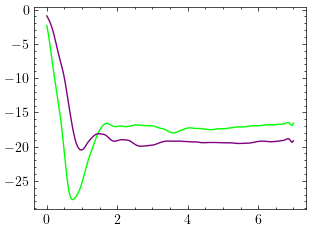

In [111]:
plt.plot(CV_grids,calculate_aveFES(TAL2_cp_grid_fes)*0.239,label="TAL2B",color='lime')
plt.plot(CV_grids,calculate_aveFES(TAL2A_cp_grid_fes)*0.239,label="TAL2A",color='purple')

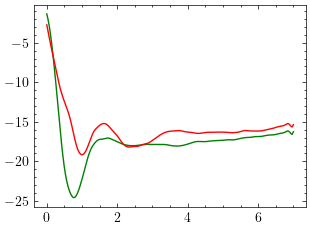

In [109]:
plt.plot(CV_grids,calculate_aveFES(TAL3_cp_grid_fes)*0.239,label="TAL3A",color='green')
plt.plot(CV_grids,calculate_aveFES(TAL3B_cp_grid_fes)*0.239,label="TAL3B",color='red')

Text(0, 0.5, '$\\Delta$G (kcal/mol)')

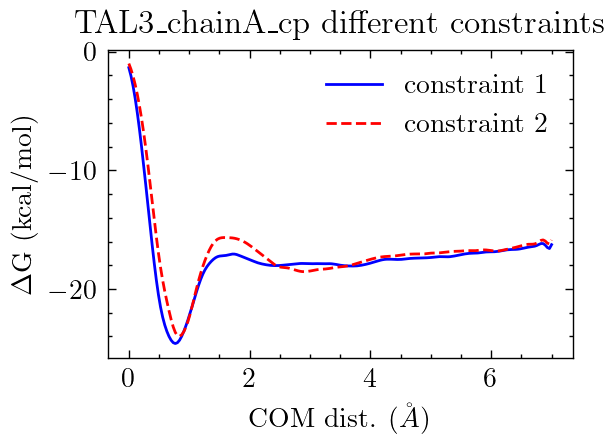

In [101]:
plt.figure(figsize=(3,2),dpi=200)
#plt.plot(CV_grids,calculate_aveFES(TAL1_cp_grid_fes)*0.239,label="TAL1",color='yellowgreen')
plt.plot(CV_grids,calculate_aveFES(TAL3_cp_grid_fes)*0.239,"-",label="constraint 1",color='blue')
#plt.plot(CV_grids,calculate_aveFES(TAL3B_cp_grid_fes)*0.239,label="TAL3B",color='red')
plt.plot(CV_grids,calculate_aveFES(TAL3A_cp_same_grid_fes)*0.239,"--",label="constraint 2",color='red')
plt.legend()
plt.title("TAL3_chainA_cp different constraints")
#plt.label("COM Dist. ($\AA)")
plt.xlabel("COM dist. ($\AA$)")
plt.ylabel("$\Delta$G (kcal/mol)")

In [15]:
print (np.argmin(calculate_aveFES(Theo_cp_grid_fes)))
print (np.argmin(calculate_aveFES(TAL1_cp_grid_fes)))
print (np.argmin(calculate_aveFES(TAL2_cp_grid_fes)))
print (np.argmin(calculate_aveFES(TAL3_cp_grid_fes)))

16
21
21
22


In [55]:
Theo_cp_deltaG = deltaG_converge(Theo_cp_grid_fes,minndx=16,nruns=66)
TAL1_cp_deltaG = deltaG_converge(TAL1_cp_grid_fes,minndx=21,nruns=60)
TAL2_cp_deltaG = deltaG_converge(TAL2_cp_grid_fes,minndx=21,nruns=34)
TAL3_cp_deltaG = deltaG_converge(TAL3_cp_grid_fes,minndx=22,nruns=65)